Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects, each with its own bounding box and a label (e.g. it can have a car and a building), and each object can be present in different parts of an image (e.g. the image can have several cars). This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights. Other applications include counting objects in images, image search, and more.

This guide shows how to:
1. Finetune DETR, a model that combines a convolutional backbone with an encoder-decoder Transformer, on the CPPE-5 dataset.
2. Use your finetuned model for inference.

# Libraries

In [1]:
!pip install -q datasets transformers accelerate timm
!pip install -q -U albumentations>1.4.5 torchmetrics pycocotools # use albumentations to augment the data

zsh:1: 1.4.5 not found


In [14]:
import torch
from datasets import load_dataset
import numpy as np
import os
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor
import albumentations as A
from functools import partial

2024-07-30 20:50:15.999263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Constants

In [3]:
# using the conditional DETR model due to its faster convergence
MODEL_NAME = "microsoft/conditional-detr-resnet-50"  # or "facebook/detr-resnet-50"
IMAGE_SIZE = 480

# Load Dataset

In [4]:
# The CPPE-5 dataset contains images with annotations identifying medical personal protective equipment (PPE)
# in the context of the COVID-19 pandemic
cppe5 = load_dataset("cppe-5")

if "validation" not in cppe5:
    split = cppe5["train"].train_test_split(0.15, seed=1337)
    cppe5["train"] = split["train"]
    cppe5["validation"] = split["test"]

# Note this dataset has 1000 images for train and validation sets and a test set with 29 images    
cppe5

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 850
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 150
    })
})

In [12]:
# Explore an example
cppe5["train"][1]

{'image_id': 613,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'width': 1280,
 'height': 720,
 'objects': {'id': [2717, 2718, 2719],
  'area': [91869, 46452, 266400],
  'bbox': [[523.0, 303.0, 339.0, 271.0],
   [605.0, 335.0, 237.0, 196.0],
   [292.0, 424.0, 900.0, 296.0]],
  'category': [1, 4, 0]}}

The examples in the dataset have the following fields:

- image_id: the example image id
- image: a PIL.Image.Image object containing the image
- width: width of the image
- height: height of the image
- objects: a dictionary containing bounding box metadata for the objects in the image:
    - id: the annotation id
    - area: the area of the bounding box 
    - bbox: the object’s bounding box (in the COCO format )
    - category: the object’s category, with possible values including Coverall (0), Face_Shield (1), Gloves (2), Goggles (3) and Mask (4)
    
Notice that the bbox field follows the COCO format, which is the format that the DETR model expects. However, the grouping of the fields inside objects differs from the annotation format DETR requires. We need to apply some preprocessing transformations before using these data for training.

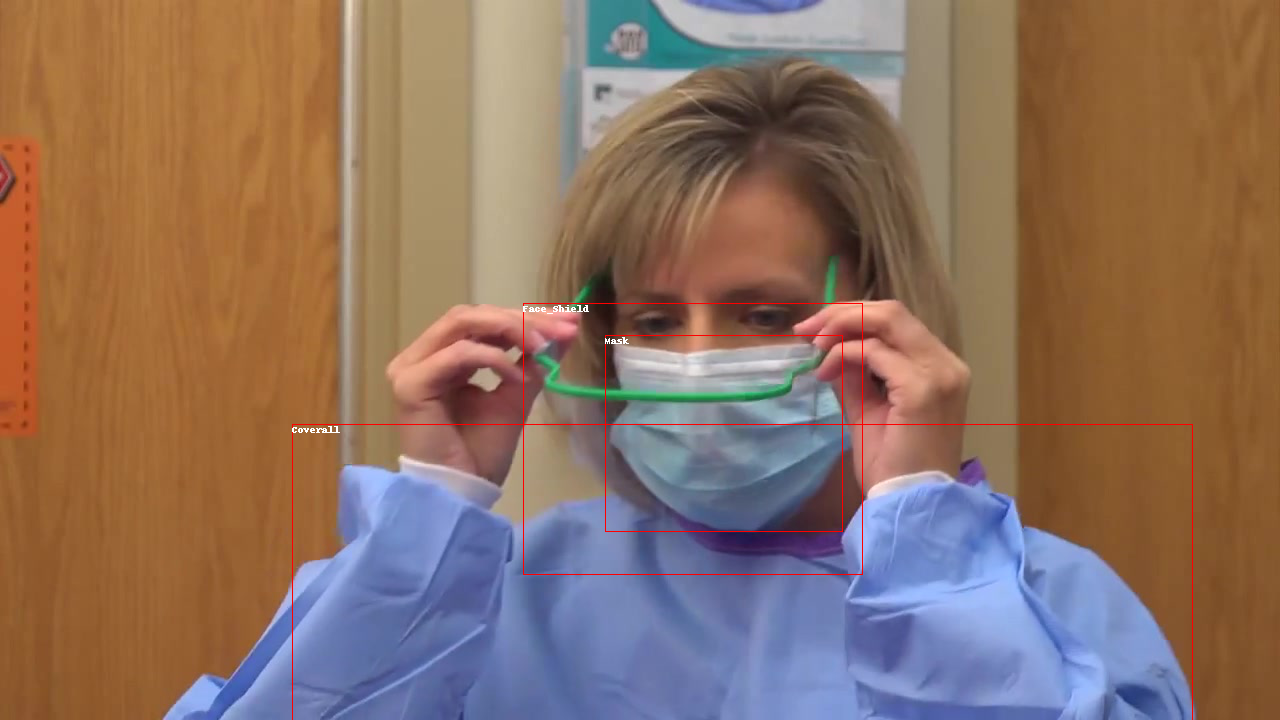

In [13]:
# Visualise an example
image = cppe5["train"][1]["image"]
annotations = cppe5["train"][1]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

# Create dictionaries that map a label id to a label class (id2label)...
# ...and the other way around (label2id)
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    
    # To visualize the bounding boxes with associated labels, get the labels from the metadata...
    # ...specifically the category field
    class_idx = annotations["category"][i]
    
    # Bounding box draw assumes COCO format (x_min, y_min, width, height)
    # Needs to be adjusted to work for other formats like (x_min, y_min, x_max, y_max)
    x, y, w, h = tuple(box)
    
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

# Preprocessing

As part of data loading and preprocessing, get familiar with the data and explore it for potential issues. 

One common problem with datasets for object detection is bounding boxes that “stretch” beyond the edge of the image. Such “runaway” bounding boxes can raise errors during training and should be addressed. There are a few examples with this issue in this dataset. To keep things simple in this guide, we will set clip=True for BboxParams in transformations below.

In [ ]:
# Preprocess matching precisely the approach used for the pre-trained model
# AutoImageProcessor takes care of processing image data to create pixel_values, pixel_mask, and labels
# NB: The image processor has some attributes that you won’t have to worry about (image_mean, image_std)
# These are the mean and standard deviation used to normalize images during the model pre-training
MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)

In [ ]:
# Apply transformations: (1) Augment images, (2) Reformat annotations to meet DETR expectations
#  Albumentations (A) ensures that transformations affect the image and update the bounding boxes accordingly
train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

In [ ]:
# The image_processor expects COCO format: {'image_id': int, 'annotations': List[Dict]}
# Function to reformat annotations for a single example
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }


In [ ]:
# Combine the image and annotation transformations to use on a batch of examples
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [ ]:

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

cppe5["train"] = cppe5["train"].with_transform(train_transform_batch)
cppe5["validation"] = cppe5["validation"].with_transform(validation_transform_batch)
cppe5["test"] = cppe5["test"].with_transform(validation_transform_batch)

# Sanity check: inspect an example
cppe5["train"][15]

In [ ]:

# Function to batch images together
# Padding images (which are now pixel_values) to the largest image in a batch
# Creating a corresponding pixel_mask to indicate which pixels are real (1) and which are padding (0)
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data
